In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from cbrain.imports import *

Using TensorFlow backend.


# Goal: New data preprocessing without normalization. Normalization on the fly in data_generator.

## Check what has gone wrong.

In [3]:
DATA_DIR = '/scratch/srasp/preprocessed_data/'

In [4]:
feature_fn = f'{DATA_DIR}purecrm_essv2_nonorm_valid_sample1_features.nc'
target_fn = f'{DATA_DIR}purecrm_essv2_nonorm_valid_sample1_targets.nc'
feature_fn_norm = f'{DATA_DIR}purecrm_essv2_valid_sample1_features.nc'
target_fn_norm = f'{DATA_DIR}purecrm_essv2_valid_sample1_targets.nc'

In [25]:
features = nc.Dataset(feature_fn)
features_norm = nc.Dataset(feature_fn_norm)

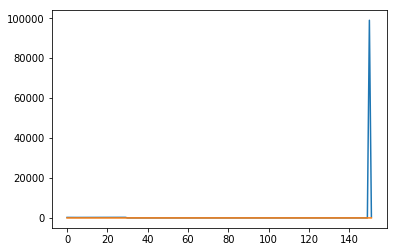

In [26]:
plt.plot(np.mean(features['features'][:1000], axis=0))
plt.plot(np.mean(features_norm['features'][:1000], axis=0))

So the features are not normalized, that seems fine!

In [27]:
targets = nc.Dataset(target_fn)
targets_norm = nc.Dataset(target_fn_norm)

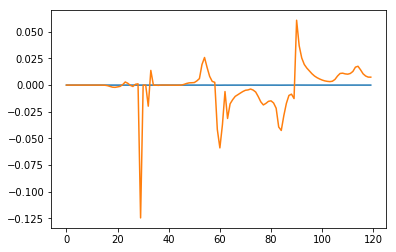

In [28]:
plt.plot(np.mean(targets['targets'][:1000], axis=0))
plt.plot(np.mean(targets_norm['targets'][:1000], axis=0))

These are also not normalized.

What about the normalization files. Are those correct?

In [29]:
norm_fn = f'{DATA_DIR}purecrm_essv2_nonorm_train_sample1_norm.nc'
norm_fn_norm = f'{DATA_DIR}purecrm_essv2_train_sample1_norm.nc'

In [30]:
norm = nc.Dataset(norm_fn)
norm_norm = nc.Dataset(norm_fn_norm)

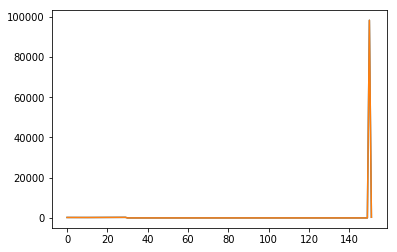

In [31]:
plt.plot(norm['feature_means'])
plt.plot(norm_norm['feature_means'])

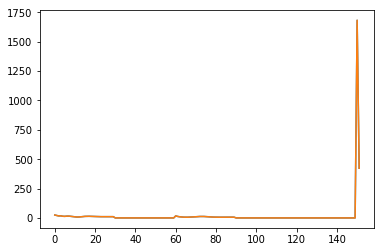

In [32]:
plt.plot(norm['feature_stds'])
plt.plot(norm_norm['feature_stds'])

In [33]:
norm

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    log: 
    Time: 2018-02-26T16:21:17

    Executed command:

    python /export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/data_processing//preprocess_aqua.py --config_file /export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/data_processing//config/pure_crm_essentials.yml --in_dir /beegfs/DATA/pritchard/srasp/Aquaplanet_enhance05/ --aqua_names=AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-*-0[5-9]-* --out_dir /scratch/srasp/preprocessed_data/ --out_pref purecrm_essv2_nonorm_train_sample1

    In directory: /export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/data_processing/config

    Git hash: fa37113fdd176b163b7ccb2b04d8e9b375f9f1dc

        
    dimensions(sizes): feature_lev(152), target_lev(120)
    variables(dimensions): int64 feature_lev(feature_lev), int64 target_lev(target_lev), float32 feature_means(feature_lev), float32 feature_stds(feature_lev), float32 feature_mins(featur

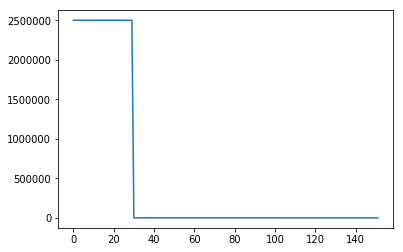

In [34]:
plt.plot(norm['target_conv'])

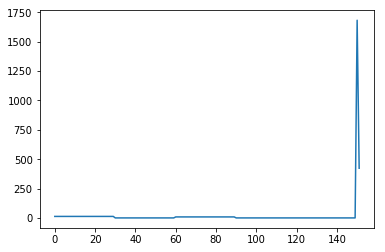

In [35]:
plt.plot(norm['feature_stds_by_var'])

 So it looks as though everything has gone well with the preprocessing. Even though I might be able to speed it up a little, which we can do later. For now let's check out the data generator and whether it produces the same results on the fly as the pre-normalized data.

In [44]:
norm.close(); features.close(); targets.close()

RuntimeError: NetCDF: Not a valid ID

## Data generator

In [52]:
from cbrain.data_generator import *

In [53]:
genobj = DataGenerator(
    DATA_DIR,
    'purecrm_essv2_nonorm_valid_sample1_features.nc',
    'purecrm_essv2_nonorm_valid_sample1_targets.nc',
    1,
    'purecrm_essv2_nonorm_train_sample1_norm.nc',
    'feature_means', 'feature_stds', None, 'target_conv',
    shuffle=False
)

Generator will have 23494656 samples in 23494656 batches
Features have shape 152; targets have shape 120


In [54]:
x, y = next(genobj.return_generator())

In [55]:
x.shape

(1, 152)

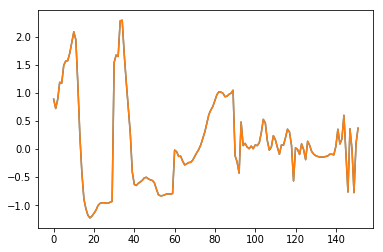

In [56]:
plt.plot(x[0])
plt.plot(features_norm['features'][0])

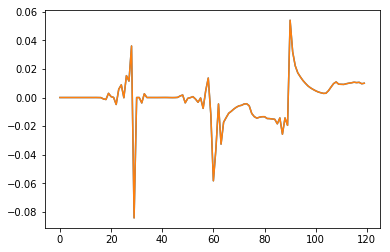

In [57]:
plt.plot(y[0])
plt.plot(targets_norm['targets'][0])

Aha, here we have found the problem!! And we fixed it! Checkpoint! Now let's see if we can speed up the preprocessing step a little. In particular, does the computation of means and stds have to take that long?

## Speed up computation of statistics

In [5]:
features = xr.open_dataset(feature_fn)

In [60]:
features

<xarray.Dataset>
Dimensions:        (feature_lev: 152, sample: 23494656)
Coordinates:
  * feature_lev    (feature_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
    time           (sample) int64 ...
    lat            (sample) float64 ...
    lon            (sample) float64 ...
    feature_names  (feature_lev) object ...
Dimensions without coordinates: sample
Data variables:
    features       (sample, feature_lev) float32 ...
Attributes:
    log:      \n    Time: 2018-02-26T17:58:09\n\n    Executed command:\n\n   ...

In [ ]:
%time mean = features.mean(dim='sample')
# This takes a long time and blows up my RAM, also interupting crashes my kernel!

In [5]:
23494656 / 16

1468416.0

In [6]:
features = xr.open_dataset(feature_fn, chunks={'sample': 1468416})

In [7]:
features

<xarray.Dataset>
Dimensions:        (feature_lev: 152, sample: 23494656)
Coordinates:
  * feature_lev    (feature_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
    time           (sample) int64 dask.array<shape=(23494656,), chunksize=(1468416,)>
    lat            (sample) float64 dask.array<shape=(23494656,), chunksize=(1468416,)>
    lon            (sample) float64 dask.array<shape=(23494656,), chunksize=(1468416,)>
    feature_names  (feature_lev) object dask.array<shape=(152,), chunksize=(152,)>
Dimensions without coordinates: sample
Data variables:
    features       (sample, feature_lev) float32 dask.array<shape=(23494656, 152), chunksize=(1468416, 152)>
Attributes:
    log:      \n    Time: 2018-02-26T17:58:09\n\n    Executed command:\n\n   ...

In [10]:
%time mean = features.mean(dim='sample', skipna=False).compute()

CPU times: user 6.99 s, sys: 15.4 s, total: 22.4 s
Wall time: 11.8 s


In [11]:
mean

<xarray.Dataset>
Dimensions:        (feature_lev: 152)
Coordinates:
  * feature_lev    (feature_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
    feature_names  (feature_lev) object 'T_C_lev00' 'T_C_lev01' 'T_C_lev02' ...
Data variables:
    features       (feature_lev) float32 223.762 217.603 201.833 220.138 ...

In [ ]:
%time std = features.std(dim='sample').compute()
# Takes quite long

In [8]:
%time std = features.std(dim='sample', skipna=False).compute()

CPU times: user 31.8 s, sys: 2min 7s, total: 2min 39s
Wall time: 43.2 s


Thats better. So skipna=False is really important.